In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/ASSM/Aleph'

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_perfect_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
cfg_var=CESM2_config()
cfg_var.year_s=1960
cfg_var.year_e=2020

cfg_var.setvar('photoC_TOT_zint_100m')
cfg_var.list()

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

{'codebase': 'e21',
 'comp': 'ocn',
 'compset': 'b',
 'dimension': 'time '
              'nlat '
              'nlon',
 'long_name': 'Total '
              'C '
              'Fixation '
              'Vertical '
              'Integral '
              '0-100m',
 'model': 'pop.h',
 'ndim': 3,
 'resol': 'f09_g17',
 'tfreq': 'month_1',
 'unit': 'mmol/m^3 '
         'cm/s',
 'var': 'photoC_TOT_zint_100m',
 'year_e': 2020,
 'year_s': 1960}


# Read dataset

In [5]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var.var]
def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


start_date = cftime.DatetimeNoLeap(cfg_var.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var.year_e+1, 1, 1)


def process_coords_hcst(ds, drop=True, except_coord_vars=['time','lon','lat', 'TLONG', 'TLAT', cfg_var.var]):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

In [6]:
# Read PFT dataset
start_time = time.time()

cfg_var.PFT_path_load(cfg_var.var)

cfg_var.PFT_ds = xr.open_mfdataset(cfg_var.PFT_file_list[0], 
                           chunks={'time': 2}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var.PFT_ensembles], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

cfg_var.PFT_ds = cfg_var.PFT_ds.rename({"concat_dim": "ens_PFT"})
new_time = cfg_var.PFT_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var.PFT_ds.time))
cfg_var.PFT_ds = cfg_var.PFT_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading PFT: ' + str(elapsed_time))

elasped time for reading PFT: 14.063806056976318


In [10]:
# Read LE dataset

start_time = time.time()


cfg_var.LE_path_load(cfg_var.var)

cfg_var.LE_ds = xr.open_mfdataset(cfg_var.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var.LE_ds = cfg_var.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var.LE_ds.time))
cfg_var.LE_ds = cfg_var.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 16.067532300949097


# Take annual means

In [14]:

pft_full_annual_mean = cfg_var.PFT_ds.groupby('time.year').mean(dim='time', skipna=True)
le_full_annual_mean = cfg_var.LE_ds.groupby('time.year').mean(dim='time', skipna=True)

ref_time=cfg_var.PFT_ds.time.groupby('time.year').mean(dim='time')

In [12]:
# 4 year moving average
pft_full_rolling_mean = pft_full_annual_mean.rolling(year=4, min_periods=4).mean()
pft_full_rolling_time_mean = pft_full_annual_mean['year'].rolling(year=4, min_periods=4).mean()
pft_full_rolling_mean = pft_full_rolling_mean.assign_coords(year=pft_full_rolling_time_mean)
valid_index = np.where(~np.isnan(pft_full_rolling_mean['year']))[0]
pft_full_rolling_mean = pft_full_rolling_mean.isel(year=valid_index)

le_full_rolling_mean = le_full_annual_mean.rolling(year=4, min_periods=4).mean()
le_full_rolling_time_mean = le_full_annual_mean['year'].rolling(year=4, min_periods=4).mean()
le_full_rolling_mean = le_full_rolling_mean.assign_coords(year=le_full_rolling_time_mean)
valid_index = np.where(~np.isnan(le_full_rolling_mean['year']))[0]
le_full_rolling_mean = le_full_rolling_mean.isel(year=valid_index)

In [15]:
start_time = time.time()

pp_PFT = xr.corr(pft_full_annual_mean[cfg_var.var], le_full_annual_mean[cfg_var.var], dim='year').compute()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for calculating correlation: ' + str(elapsed_time))

elasped time for calculating correlation: 13.876116752624512


In [16]:
def pop_add_cyclic(da):
        #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
        #This doesn't work with Dask (DA should be loaded)
        #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
        #Output is DA
        nj = da.TLAT.shape[0]
        ni = da.TLONG.shape[1]
        xL = int(ni/2 - 1)
        xR = int(xL + ni)
        tlon = da.TLONG.data
        tlat = da.TLAT.data
        tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
        lon  = np.concatenate((tlon, tlon + 360.), 1)
        lon = lon[:, xL:xR]
        if ni == 320:
            lon[367:-3, 0] = lon[367:-3, 0] + 360.
        lon = lon - 360.
        lon = np.hstack((lon, lon[:, 0:1] + 360.))
        if ni == 320:
            lon[367:, -1] = lon[367:, -1] - 360.
        #-- trick cartopy into doing the right thing:
        #   it gets confused when the cyclic coords are identical
        lon[:, 0] = lon[:, 0] - 1e-8
        #-- periodicity
        lat = np.concatenate((tlat, tlat), 1)
        lat = lat[:, xL:xR]
        lat = np.hstack((lat, lat[:,0:1]))
        TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
        TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
        # copy vars
        v = da.name
        v_dims = da.dims
        # determine and sort other dimensions
        other_dims = set(v_dims) - {'nlat', 'nlon'}
        other_dims = tuple([d for d in v_dims if d in other_dims])
        lon_dim = da.dims.index('nlon')
        field = da.data
        field = np.concatenate((field, field), lon_dim)
        field = field[:, xL:xR]
        field = np.concatenate((field, field[:, 0:1]), lon_dim)
        dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
        dao = dao.assign_coords(TLONG=TLONG)
        dao = dao.assign_coords(TLAT=TLAT)
        return dao

In [18]:
pp_PFT

<xarray.DataArray 'photoC_TOT_zint_100m' (ens_PFT: 1, nlat: 384, nlon: 320,
                                          ens_LE: 1)>
array([[[[       nan],
         [       nan],
         [       nan],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[       nan],
         [       nan],
         [       nan],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[0.12098346],
         [0.00178795],
         [0.07089933],
         ...,
...
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[       nan],
         [       nan],
         [       nan],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[       nan],
         [       nan],
         [       nan],
         ...,
         [       nan],
         [       nan],
         [       nan]]]])
Coordinates:
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * ens_PFT  (ens_PFT) int64 0
  * ens_LE   (ens_LE) int64 0
Dimensions without coordinates: nlat, nlon
Attributes:
    name:     photoC_TOT_zint_100m

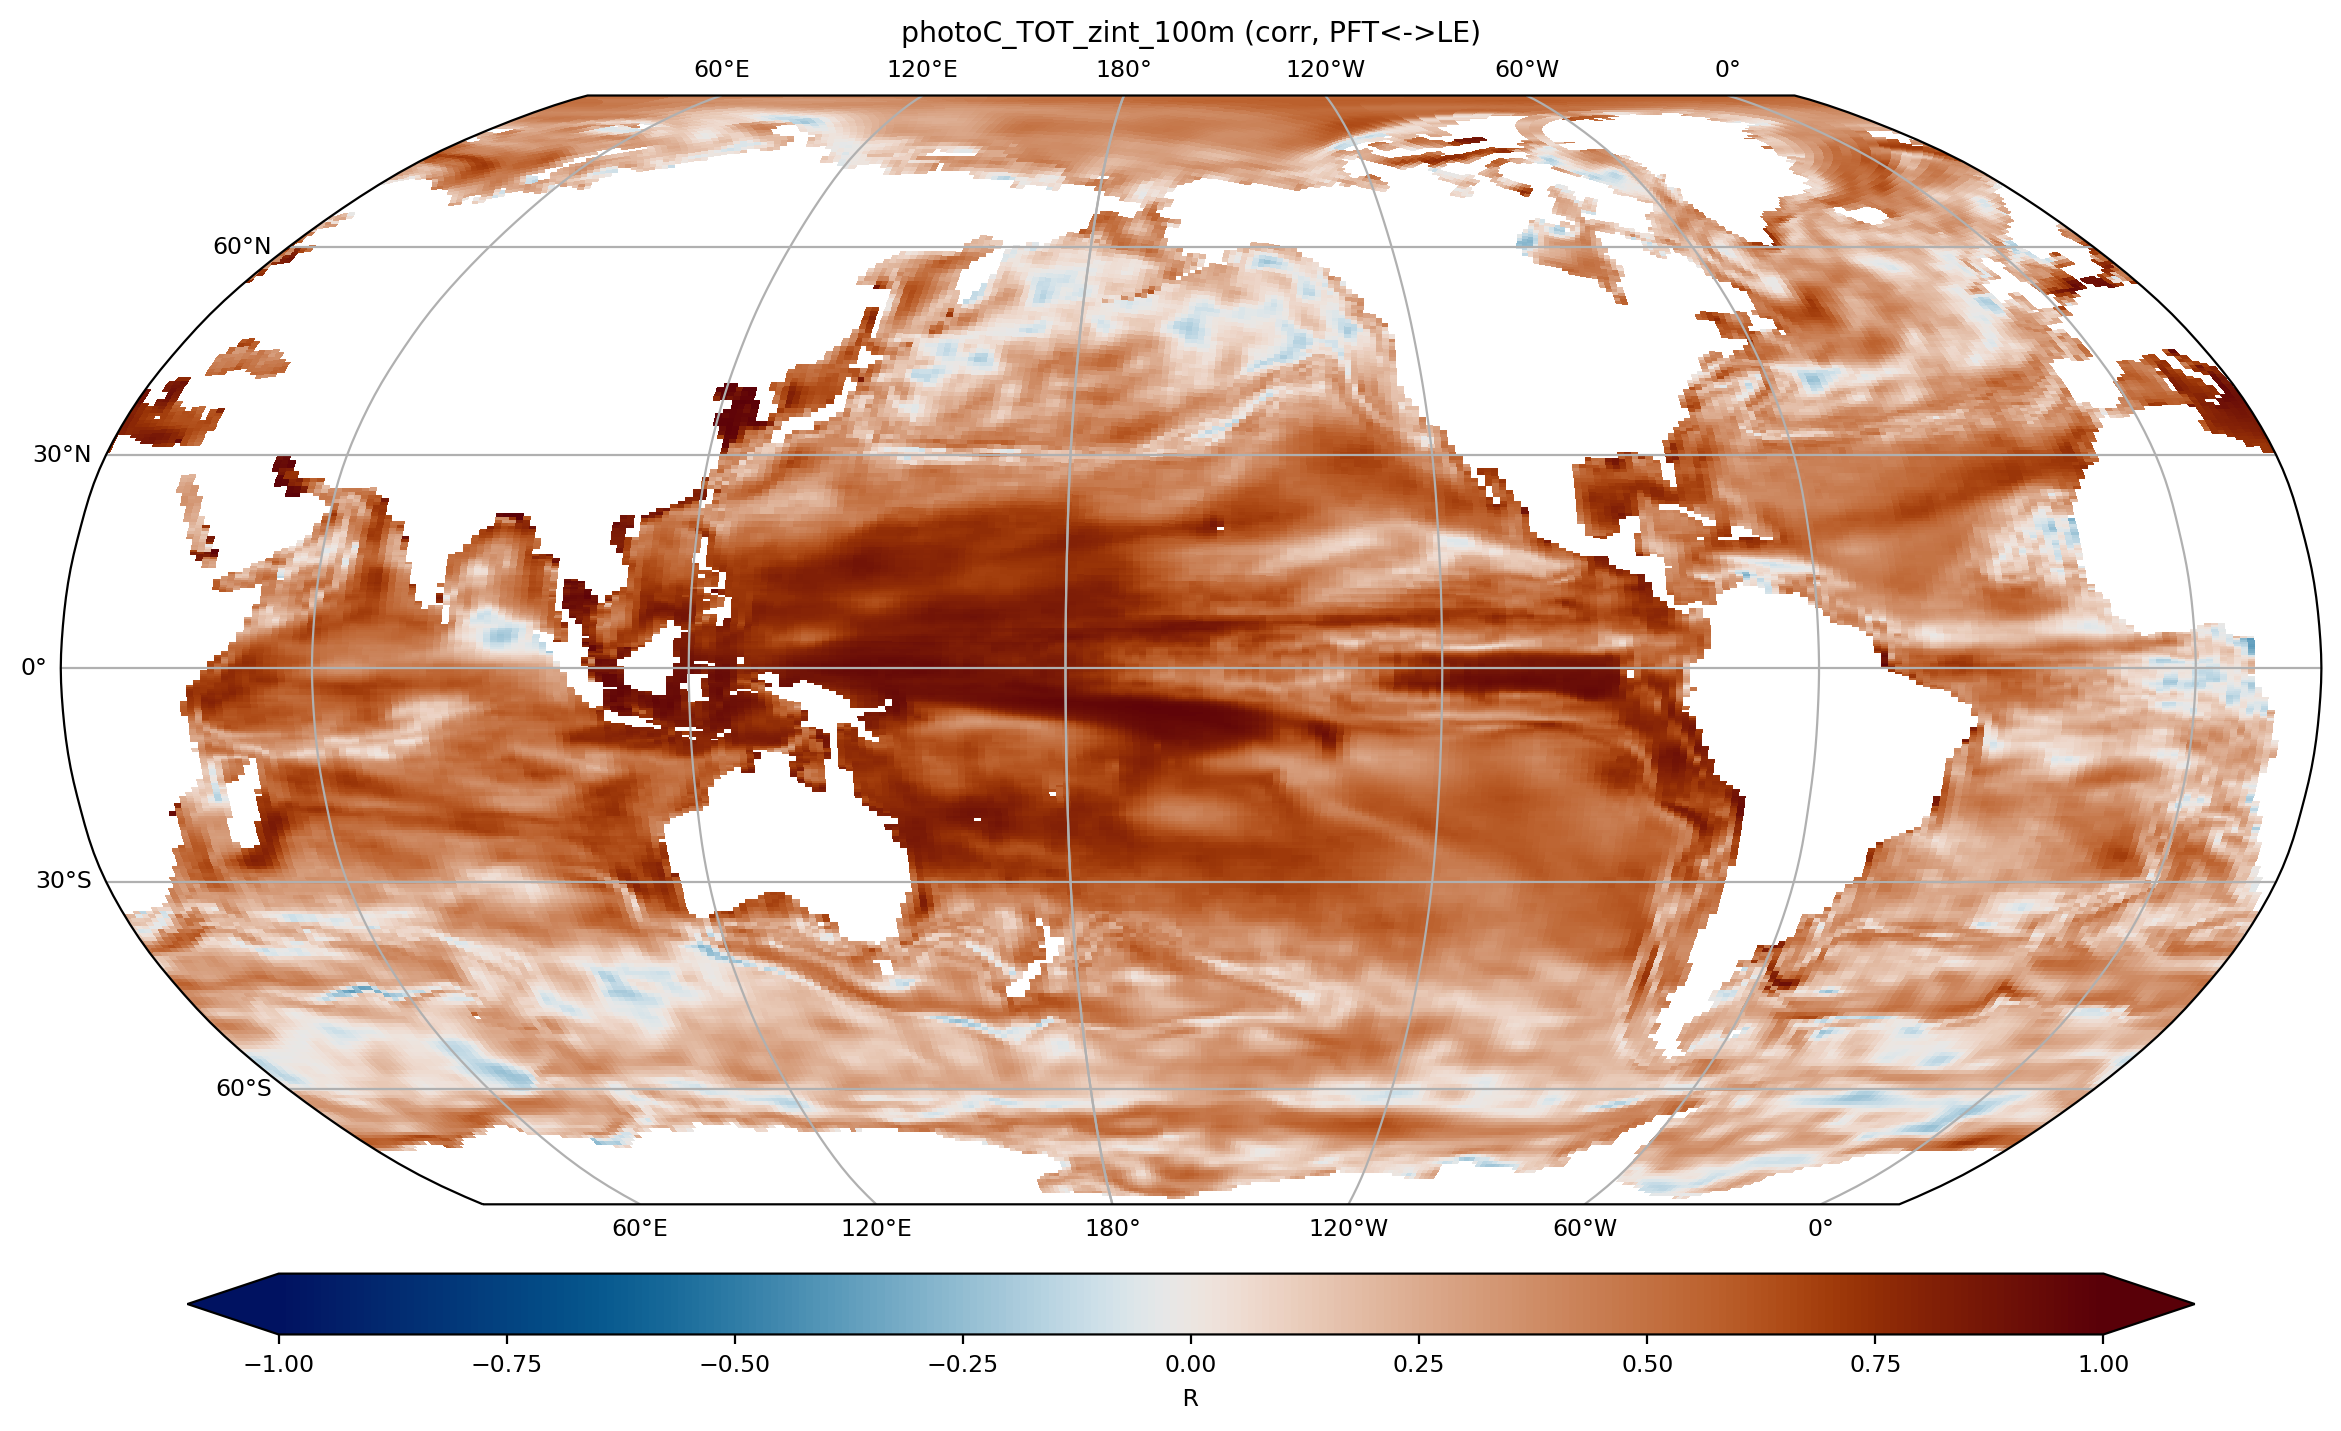

elasped time for calculating correlation: 4.03072190284729


In [20]:
# plot for corr(PFT <-> LE)

start_time = time.time()

varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

data_array=pp_PFT.isel(ens_PFT=0).isel(ens_LE=0)

data_array.attrs['name'] = cfg_var.var

if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT

projection = ccrs.Robinson(central_longitude=200)

plt.rcParams.update({'font.size': 8.5})
fig, ax2 = plt.subplots(1, 1, figsize=(18.5, 9), dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection})

cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}
if cfg_var.comp=='ocn' or cfg_var.comp=='ice':
    # plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=0.05, vmin=-0.05,cmap=cm.vik, cbar_kwargs=cbar_kwargs)
    plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax2, transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, cbar_kwargs=cbar_kwargs)

else:
    plt1=data_array.isel(concat_dim=0).mean(dim='time').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmax=30, vmin=0, cmap=cmocean.cm.deep, cbar_kwargs=cbar_kwargs)

ax2.set_title(f'{varn} (corr, PFT<->LE)')
ax2.gridlines(draw_labels=True) 

ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}°'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}°'))

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for calculating correlation: ' + str(elapsed_time))

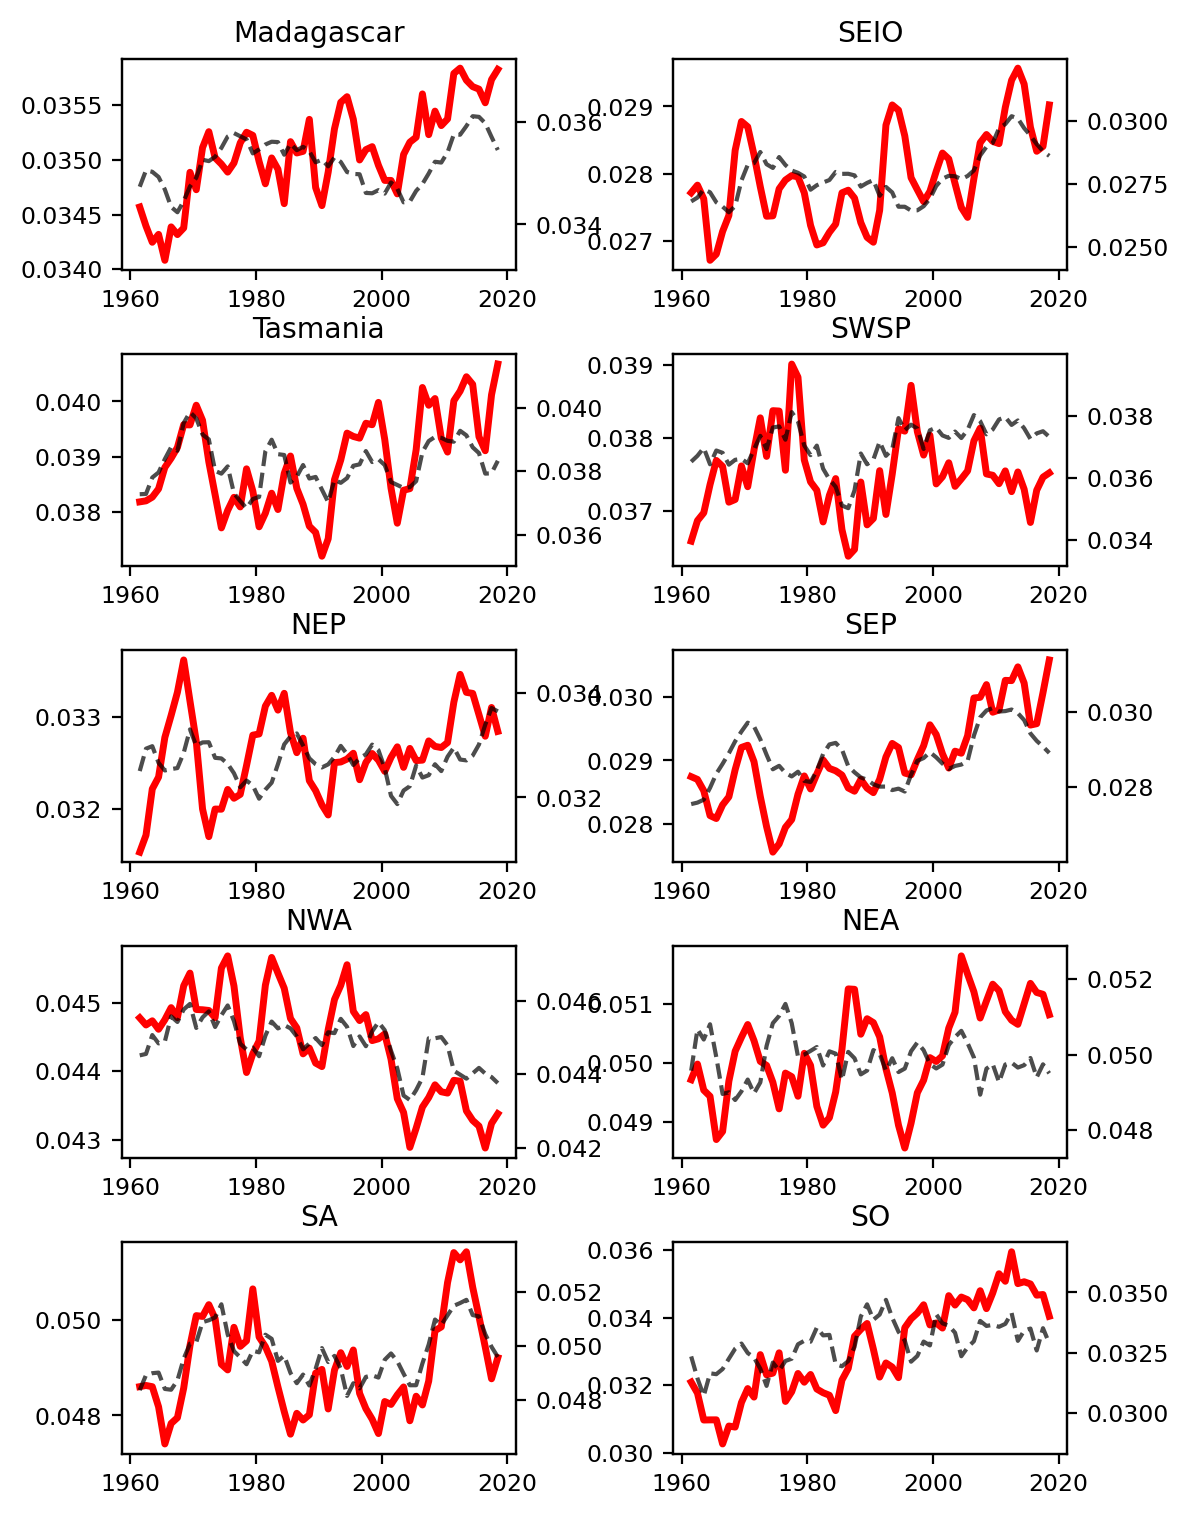

In [30]:
def create_trapezoid_path(coords):
    """사다리꼴 좌표를 받아 경로 생성"""
    return mpath.Path(coords)

def filter_region_by_trapezoid(coords, lons, lats, data):
    """사다리꼴 경로 내부에 있는 점들을 필터링"""
    trapezoid_path = create_trapezoid_path(coords)
    points = np.vstack((lons.ravel(), lats.ravel())).T
    inside_trapezoid = trapezoid_path.contains_points(points).reshape(lons.shape)
    return data.where(inside_trapezoid)

def plot_time_series(ax, ax2, pft_time_series_data, le_time_series_data, cfg_var):
    """한 subplot에 대한 time series 및 fill_between 플롯 생성"""
     
    # PFT
    ax.plot(pft_time_series_data.year.values, pft_time_series_data[cfg_var.var].values, color='red', linewidth=2.5)

    # LE
    ax2.plot(le_time_series_data.year.values, le_time_series_data[cfg_var.var].values, 
             color='black', alpha=0.7, linewidth=1.5, linestyle='--')
    
    # y축 범위 조정
    ymin, ymax = ax2.get_ylim()
    ax2.set_ylim(ymin - (ymax - ymin) / 2, ymax + (ymax - ymin) / 2)

def process_region(ax, ax2, coords, lons, lats, cfg_var, pft_data, le_data):
    """영역을 필터링하고 플로팅"""
    pft_filtered = filter_region_by_trapezoid(coords, lons, lats, pft_data)
    le_filtered = filter_region_by_trapezoid(coords, lons, lats, le_data)

    # 위도에 따른 가중치 적용 후 평균 계산
    weights = np.cos(np.deg2rad(pft_filtered['TLAT']))
    pft_time_series_data = pft_filtered.weighted(weights).mean(dim=['nlat', 'nlon'], skipna=True).compute()
    le_time_series_data = le_filtered.weighted(weights).mean(dim=['nlat', 'nlon'], skipna=True).compute()

    plot_time_series(ax, ax2, pft_time_series_data, le_time_series_data, cfg_var)

# 좌표 설정 (사전으로 관리)
regions = {
    "Madagascar": [[30, -33], [70, -33], [70, -20], [30, -20]],
    "SEIO": [[50, -45], [115, -45], [115, -24], [50, -41]],
    "Tasmania": [[130, -48], [175, -48], [175, -35], [130, -35]],
    "SWSP": [[148, -25], [192, -18], [192, -15], [148, -10]],
    "NEP": [[215, 15], [250, 15], [250, 50], [230, 50]],
    "SEP": [[250, -50], [290, -50], [290, -13], [250, -13]],
    "NWA": [[285, 25], [340, 32], [340, 40], [285, 40]],
    "NEA": [[310, 10], [340, 10], [340, 26], [310, 26]],
    "SA": [[-40, -35], [10, -30], [10, -18], [-40, -18]],
    "SO": [[-50, -50], [20, -50], [20, -37], [-50, -37]],
}

# 그림 생성
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(6, 6*1.414), dpi=200, constrained_layout=False)
lons = cfg_var.PFT_ds.TLONG.values
lats = cfg_var.PFT_ds.TLAT.values

# 영역에 대해 반복 처리
pft_full_rolling_mean['TLAT']=ds_grid.TLAT
le_full_rolling_mean['TLAT']=ds_grid.TLAT

for idx, (region_name, coords) in enumerate(regions.items()):
    i, j = divmod(idx, 2)
    ax2 = ax[i, j].twinx()  # 새로운 축 생성
    process_region(ax[i, j], ax2, coords, lons, lats, cfg_var, pft_full_rolling_mean, le_full_rolling_mean)
    ax[i, j].set_title(region_name)

# 전체 플롯 관련 설정
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.subplots_adjust(hspace=0.4, wspace=0.4) # vertical, horizontal

plt.show()

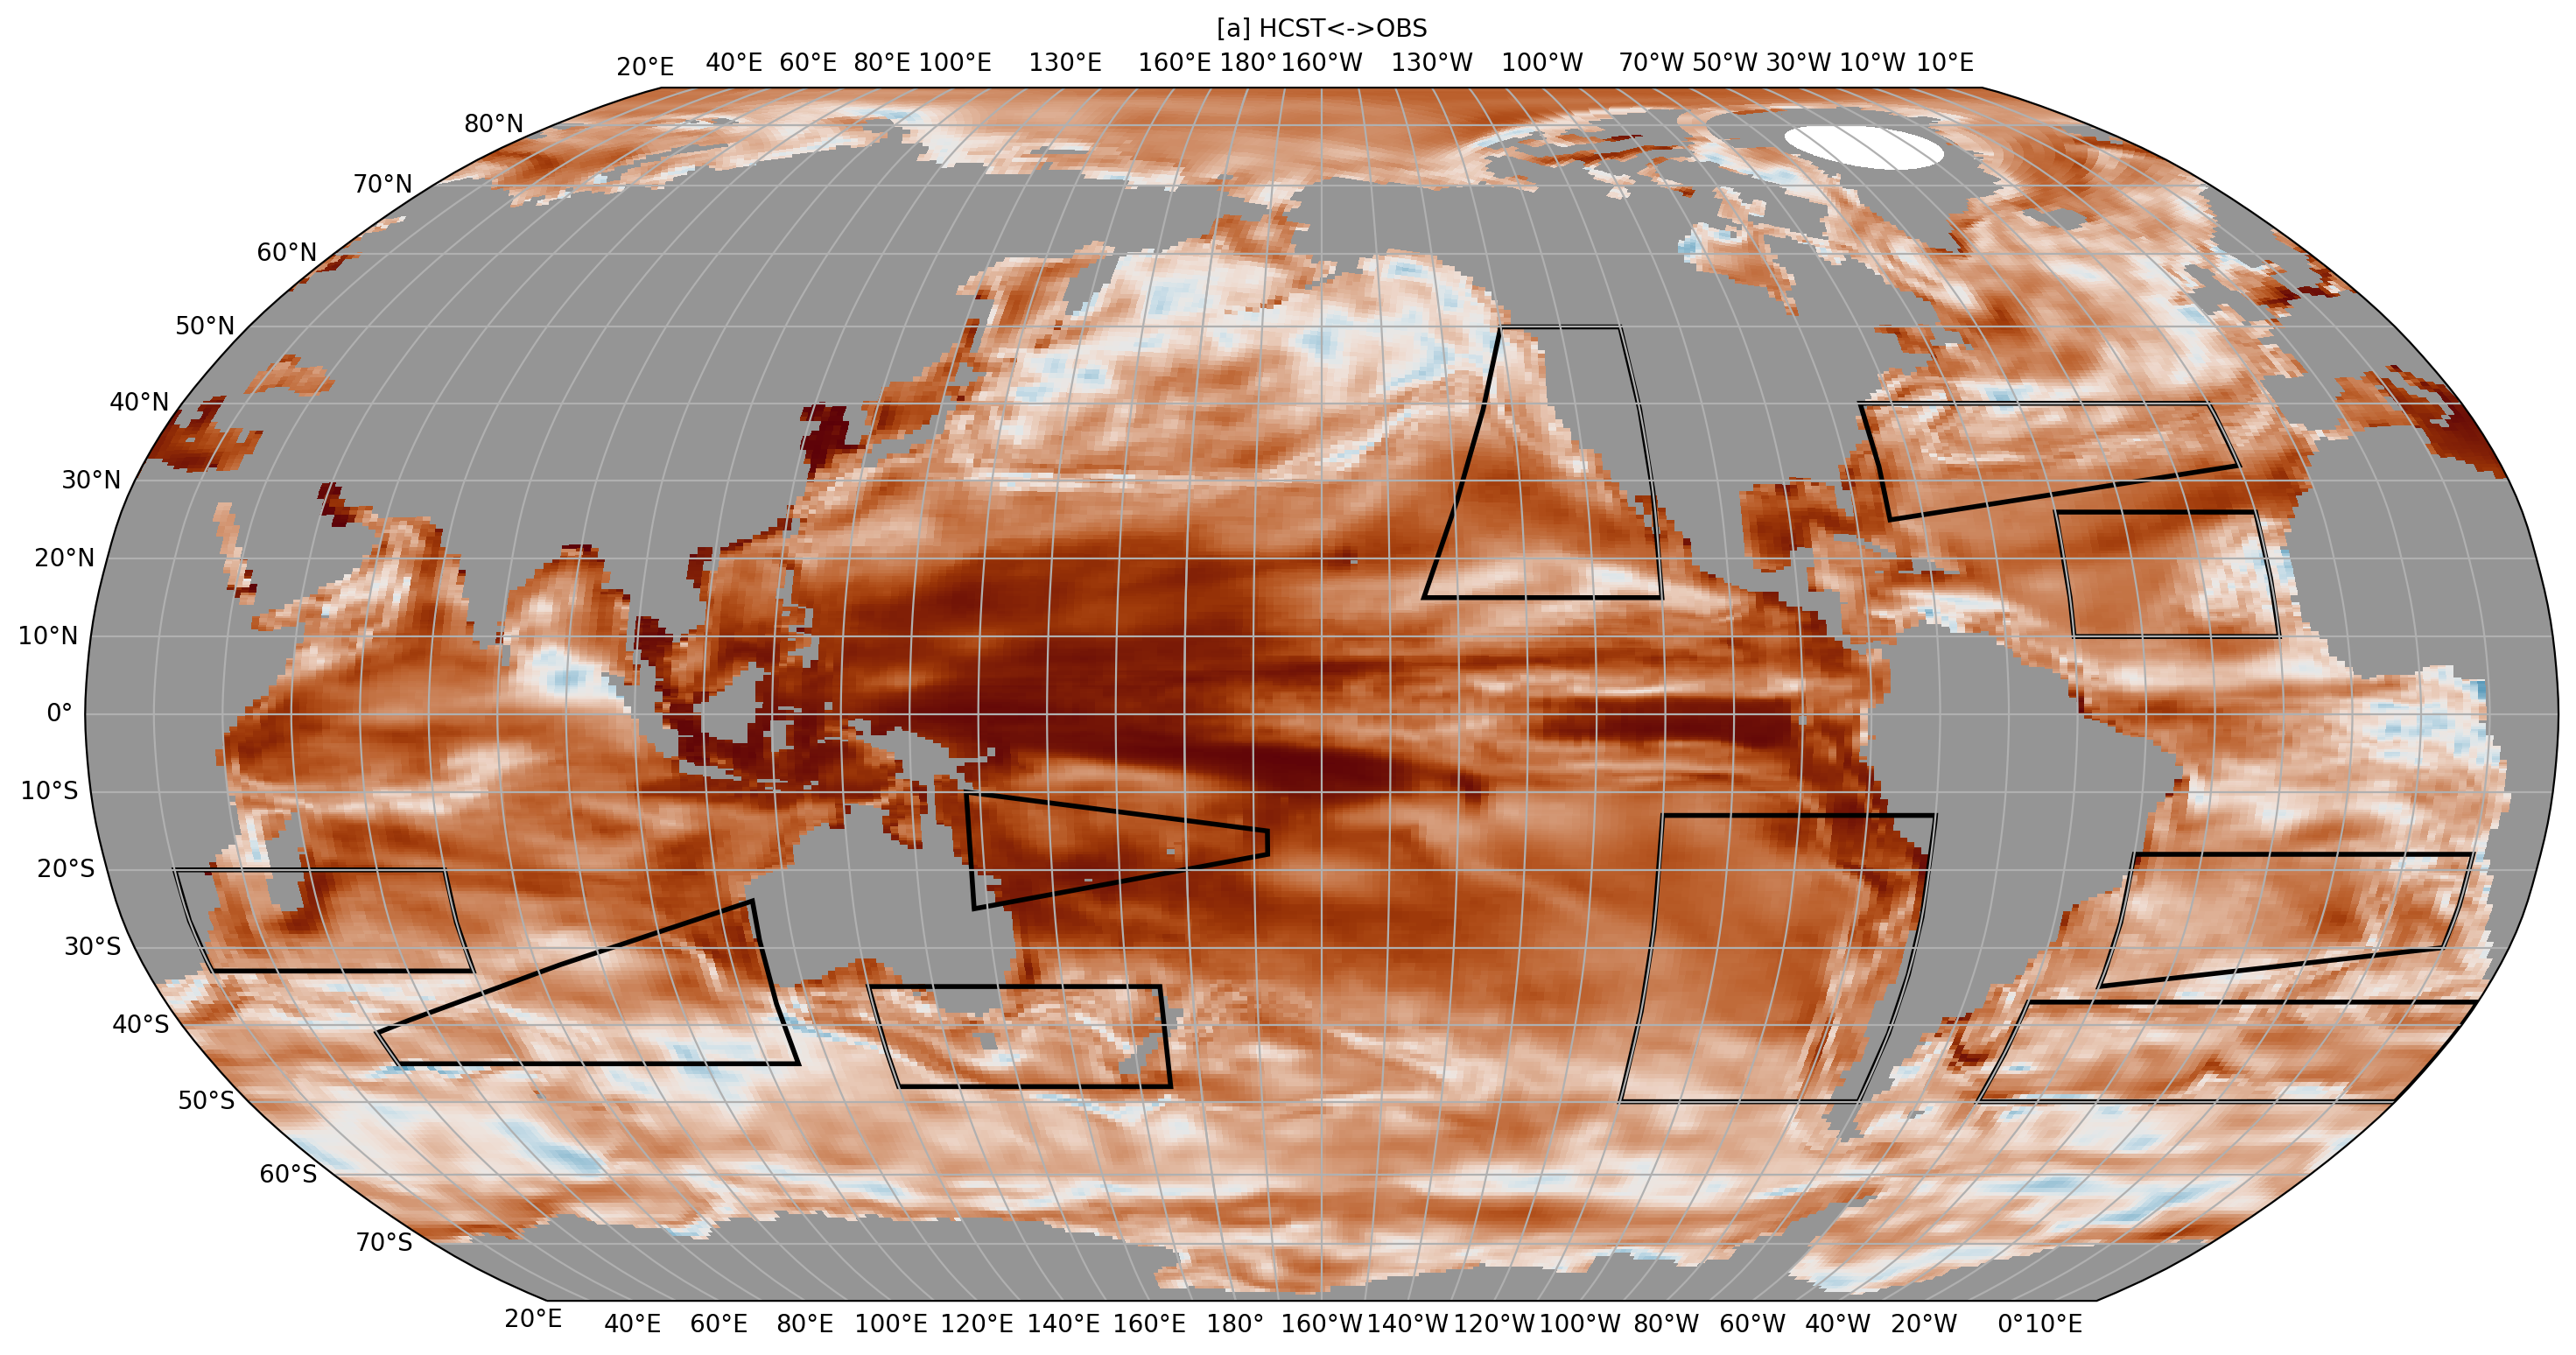

elasped time for plot: 8.356891632080078


In [32]:
# practice for panels (with boxes)

start_time = time.time()

varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

data_array=pp_PFT.isel(ens_PFT=0).isel(ens_LE=0)

data_array.attrs['name'] = cfg_var.var

mask_land = np.isnan(data_array)  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)

if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT
    mask_land_numeric['TLONG']=ds_grid.TLONG
    mask_land_numeric['TLAT']=ds_grid.TLAT

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

projection = ccrs.Robinson(central_longitude=200)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)

grid_spacing = 1

plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', 
                ax=axes, transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes, x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

gridlines = axes.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

gridlines.xlocator = mticker.FixedLocator(np.arange(-180, 181, 10))  # 경도는 -180도에서 180도까지 10도 간격
gridlines.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))    # 위도는 -90도에서 90도까지 10도 간격

gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

axes.set_title('[a] HCST<->OBS')


# 1. Madagascar
trapezoid_coords = [
    [30.0, -33],  # 왼쪽 아래
    [70, -33],  # 오른쪽 아래
    [70, -20],  # 오른쪽 위
    [30, -20]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#2. SEIO
trapezoid_coords = [
    [50, -45],  # 왼쪽 아래
    [115, -45],  # 오른쪽 아래
    [115, -24],  # 오른쪽 위
    [50, -41]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#3. Tasmania
trapezoid_coords = [
    [130, -48],  # 왼쪽 아래
    [175, -48],  # 오른쪽 아래
    [175, -35],  # 오른쪽 위
    [130, -35]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#4. SWSP
trapezoid_coords = [
    [148, -25],  # 왼쪽 아래
    [192, -18],  # 오른쪽 아래
    [192, -15],  # 오른쪽 위
    [148, -10]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#5. NEP
trapezoid_coords = [
    [215, 15],  # 왼쪽 아래
    [250, 15],  # 오른쪽 아래
    [250, 50],  # 오른쪽 위
    [230, 50]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#6. SEP
trapezoid_coords = [
    [250, -50],  # 왼쪽 아래
    [290, -50],  # 오른쪽 아래
    [290, -13],  # 오른쪽 위
    [250, -13]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#7. NWA
trapezoid_coords = [
    [-75, 25],  # 왼쪽 아래
    [-20, 32],  # 오른쪽 아래
    [-20, 40],  # 오른쪽 위
    [-75, 40]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#8. NEA
trapezoid_coords = [
    [-50, 10],  # 왼쪽 아래
    [-20, 10],  # 오른쪽 아래
    [-20, 26],  # 오른쪽 위
    [-50, 26]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#9. SA
trapezoid_coords = [
    [-40, -35],  # 왼쪽 아래
    [10, -30],  # 오른쪽 아래
    [10, -18],  # 오른쪽 위
    [-40, -18]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)


#10. SO
trapezoid_coords = [
    [-50, -50],  # 왼쪽 아래
    [20, -50],  # 오른쪽 아래
    [20, -37],  # 오른쪽 위
    [-50, -37]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for plot: ' + str(elapsed_time))

Target point: lon=60, lat=-25
Closest point indices: lon_idx=88, lat_idx=102
Closest point coordinates: lon=59.5625016574775, lat=-25.097725426393733
PFT_values: values=[0.03060159 0.03033022 0.03017304 0.03045999 0.03006086 0.03043524
 0.03071074 0.03112055 0.0323599  0.03259625 0.03271663 0.03210094
 0.03074485 0.0297288  0.02945939 0.02972252 0.02996859 0.03055794
 0.03120127 0.03108163 0.03110145 0.0315646  0.03127899 0.03096711
 0.0308745  0.03023383 0.02947491 0.02948049 0.02959495 0.02941228
 0.02971895 0.03046027 0.03062147 0.0308371  0.03110716 0.03051804
 0.03124123 0.0315979  0.03185787 0.03196662 0.03133001 0.03062667
 0.0308544  0.03078696 0.03084473 0.03168849 0.03113878 0.03149147
 0.03160803 0.03147433 0.03181911 0.03208579 0.03173447 0.03120085
 0.03108585 0.03064635 0.0310242  0.03184445]
Target point: lon=108, lat=-34
Closest point indices: lon_idx=131, lat_idx=85
Closest point coordinates: lon=107.93750300363452, lat=-33.81089045387643
PFT_values: values=[0.03382085

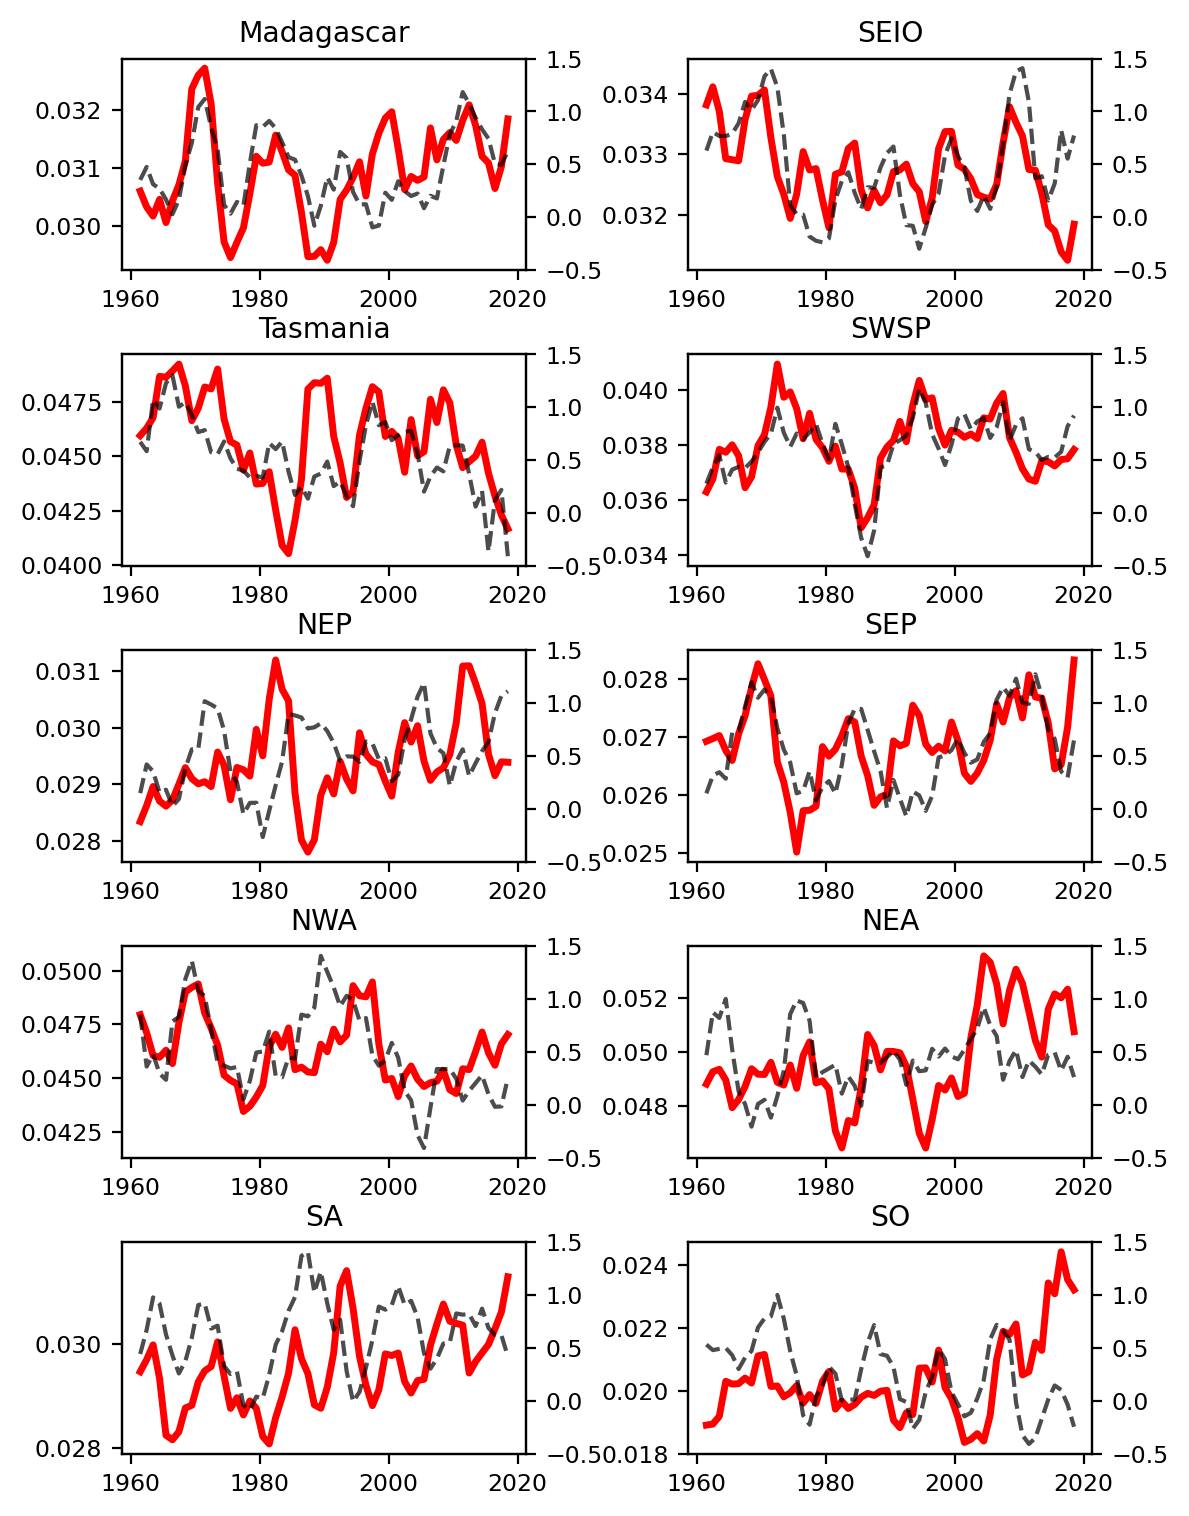

In [43]:


def process_point(ax, ax2, point, cfg_var, pft_data, le_data):
    """특정 지점의 time series를 필터링하고 플로팅"""
    target_lon, target_lat = point
    # target_lon = target_lon % 360

    # 모든 지점에서의 거리 계산
    distances = np.sqrt(
        (le_data.TLONG - target_lon) ** 2 + (le_data.TLAT - target_lat) ** 2
    )

    # 전체 배열에서 가장 가까운 지점의 인덱스 찾기
    flat_idx = distances.argmin()
    lat_idx, lon_idx = np.unravel_index(flat_idx, distances.shape)

    # 디버깅 출력
    print(f"Target point: lon={target_lon}, lat={target_lat}")
    print(f"Closest point indices: lon_idx={lon_idx}, lat_idx={lat_idx}")
    print(f"Closest point coordinates: lon={le_data.TLONG[lat_idx, lon_idx].values}, lat={le_data.TLAT[lat_idx, lon_idx].values}")

    # plot_time_series 호출
    plot_time_series_point(ax, ax2, lon_idx, lat_idx, pft_data, le_data, cfg_var)

# def process_region(ax, ax2, coords, lons, lats, cfg_var, pft_data, le_data):
#     """영역을 필터링하고 플로팅"""
#     pft_filtered = filter_region_by_trapezoid(coords, lons, lats, pft_data)
#     le_filtered = filter_region_by_trapezoid(coords, lons, lats, le_data)

#     # 위도에 따른 가중치 적용 후 평균 계산
#     weights = np.cos(np.deg2rad(pft_filtered['TLAT']))
#     pft_time_series_data = pft_filtered.weighted(weights).mean(dim=['nlat', 'nlon'], skipna=True).compute()
#     le_time_series_data = le_filtered.weighted(weights).mean(dim=['nlat', 'nlon'], skipna=True).compute()

#     plot_time_series(ax, ax2, pft_time_series_data, le_time_series_data, cfg_var)


def plot_time_series_point(ax, ax2, lon_idx, lat_idx, pft_data, le_data, cfg_var):
    # """한 subplot에 대한 time series 및 fill_between 플롯 생성"""
    # LE 데이터
    pft_point = pft_data.isel(nlon=lon_idx, nlat=lat_idx)[cfg_var.var].squeeze()
    ax.plot(pft_data.year.values, pft_point.values, color='red', linewidth=2.5)
    print(f"PFT_values: values={pft_point.values}")

    le_point = le_data.isel(nlon=lon_idx, nlat=lat_idx)[cfg_var.var].squeeze()
    ax.plot(le_data.year.values, le_point.values, 
             color='black', alpha=0.7, linewidth=1.5, linestyle='--')

    # y축 범위 조정
    ymin, ymax = ax2.get_ylim()
    ax2.set_ylim(ymin - (ymax - ymin) / 2, ymax + (ymax - ymin) / 2)


# def plot_time_series(ax, ax2, pft_time_series_data, le_time_series_data, cfg_var):
#     """한 subplot에 대한 time series 및 fill_between 플롯 생성"""
     
#     # PFT
#     ax.plot(pft_time_series_data.year.values, pft_time_series_data[cfg_var.var].values, color='red', linewidth=2.5)

#     # LE
#     ax2.plot(le_time_series_data.year.values, le_time_series_data[cfg_var.var].values, 
#              color='black', alpha=0.7, linewidth=1.5, linestyle='--')
    
#     # y축 범위 조정
#     ymin, ymax = ax2.get_ylim()
#     ax2.set_ylim(ymin - (ymax - ymin) / 2, ymax + (ymax - ymin) / 2)





points = {
    "Madagascar": (60, -25),  # (lon, lat)
    "SEIO": (108, -34),
    "Tasmania": (151, -42),
    "SWSP": (170, -15),
    "NEP": (240, 19),
    "SEP": (267, -18),
    "NWA": (301, 34),
    "NEA": (320, 15),
    "SA": (330, -28),
    "SO": (345, -47),
}


# 그림 생성
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(6, 6*1.414), dpi=200, constrained_layout=False)
lons = cfg_var.PFT_ds.TLONG.values
lats = cfg_var.PFT_ds.TLAT.values

# 영역에 대해 반복 처리
pft_full_rolling_mean['TLAT']=ds_grid.TLAT
le_full_rolling_mean['TLAT']=ds_grid.TLAT

for idx, (point_name, point_coords) in enumerate(points.items()):
    i, j = divmod(idx, 2)
    ax2 = ax[i, j].twinx()  # 새로운 축 생성
    process_point(ax[i, j], ax2, point_coords, cfg_var, pft_full_rolling_mean, le_full_rolling_mean)
    ax[i, j].set_title(point_name)

# 전체 플롯 관련 설정
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.subplots_adjust(hspace=0.4, wspace=0.4) # vertical, horizontal

plt.show()

Target point: lon=60, lat=-25
Closest point indices: lon_idx=88, lat_idx=102
Closest point coordinates: lon=59.5625016574775, lat=-25.097725426393733
Target point: lon=108, lat=-34
Closest point indices: lon_idx=131, lat_idx=85
Closest point coordinates: lon=107.93750300363452, lat=-33.81089045387643
Target point: lon=151, lat=-42
Closest point indices: lon_idx=169, lat_idx=70
Closest point coordinates: lon=150.68750419326165, lat=-41.82458618467137
Target point: lon=170, lat=-15
Closest point indices: lon_idx=186, lat_idx=131
Closest point coordinates: lon=169.81250472546324, lat=-14.866167536224738
Target point: lon=240, lat=19
Closest point indices: lon_idx=248, lat_idx=253
Closest point coordinates: lon=239.65127946577803, lat=19.15717011943143
Target point: lon=267, lat=-18
Closest point indices: lon_idx=272, lat_idx=120
Closest point coordinates: lon=266.5625074177773, lat=-18.144994846960564
Target point: lon=301, lat=34
Closest point indices: lon_idx=302, lat_idx=288
Closest po

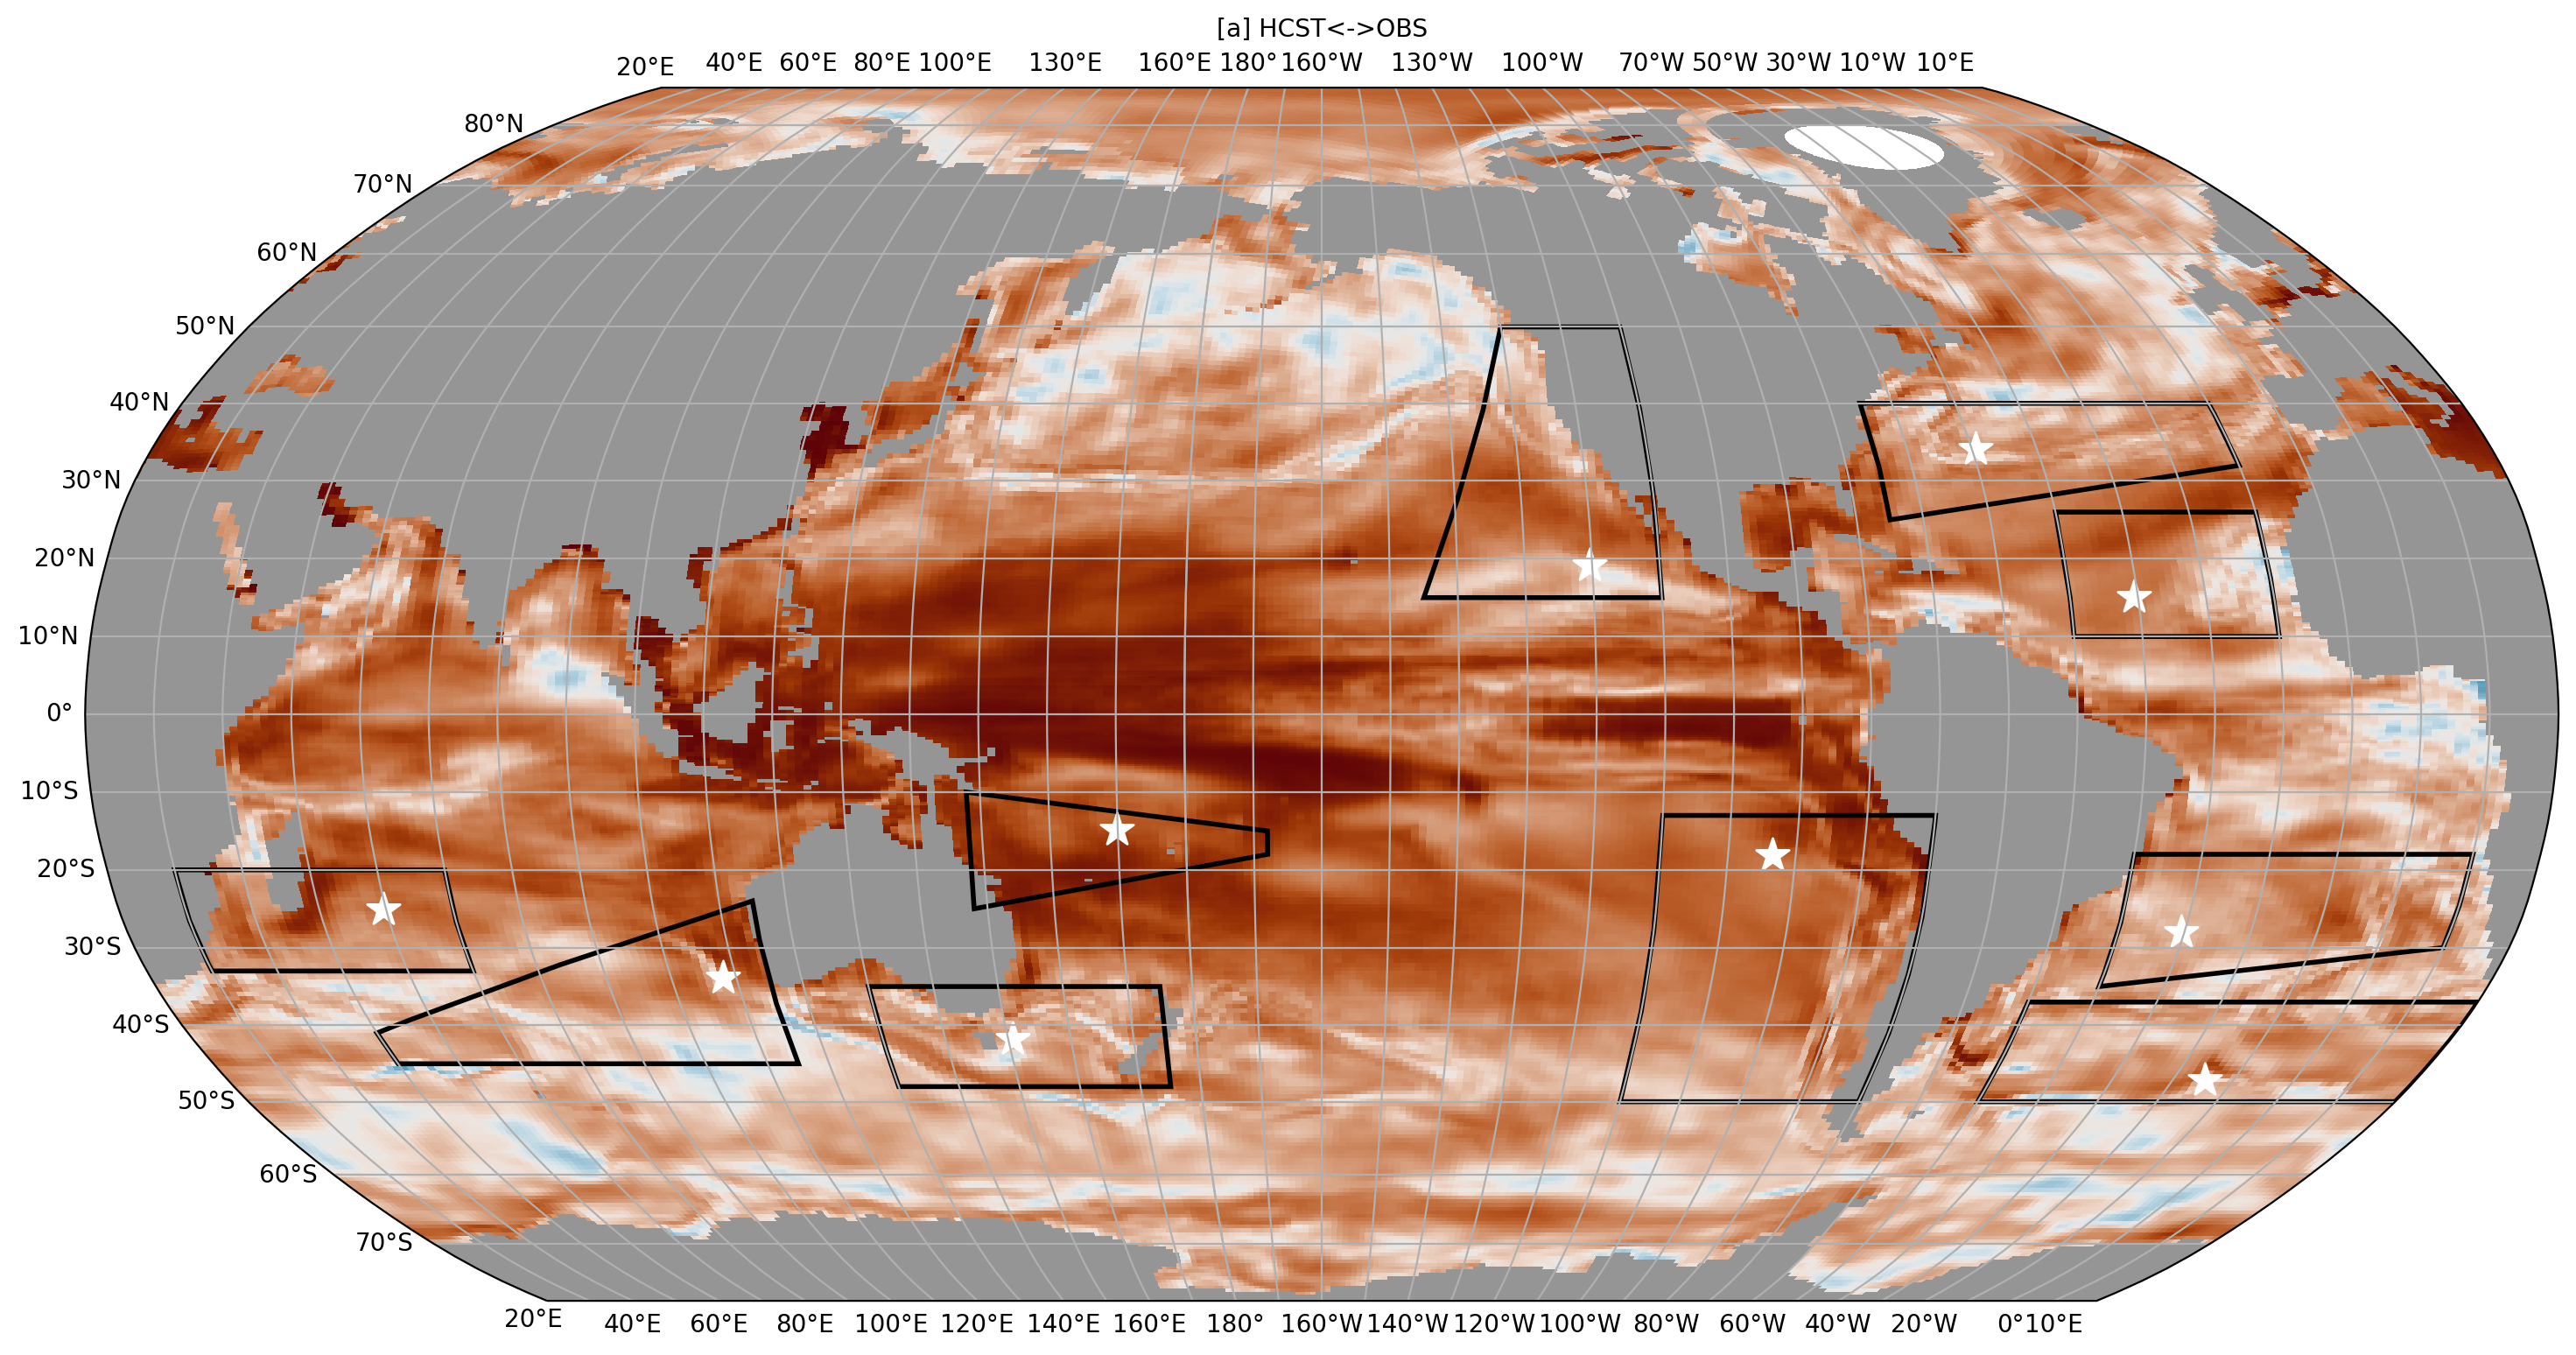

elasped time for plot: 14.235099792480469


In [36]:
# practice for panels (with boxes)

start_time = time.time()

varn=cfg_var.var #example

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

data_array=pp_PFT.isel(ens_PFT=0).isel(ens_LE=0)

data_array.attrs['name'] = cfg_var.var

mask_land = np.isnan(data_array)  # 육지(NaN인 지역)
mask_land_numeric = mask_land.astype(int)

if cfg_var.var == 'SST':
    data_array = data_array.where(data_array != 0, np.nan)
if cfg_var.comp=='ocn':
    data_array['TLONG']=ds_grid.TLONG
    data_array['TLAT']=ds_grid.TLAT
    mask_land_numeric['TLONG']=ds_grid.TLONG
    mask_land_numeric['TLAT']=ds_grid.TLAT

if cfg_var.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

projection = ccrs.Robinson(central_longitude=200)
cbar_kwargs={'orientation':'horizontal','pad':0.05,'shrink':0.7, 'label':' R ', 'aspect':33, 'extend': 'both'}

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18.5, 9), 
             dpi=200, facecolor='w', edgecolor='k', subplot_kw={'projection': projection}, constrained_layout=False)

grid_spacing = 1

plt1=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', 
                ax=axes, transform=ccrs.PlateCarree(), vmax=1, vmin=-1,cmap=cm.vik, add_colorbar=False)
land1 = pop_add_cyclic(mask_land_numeric.where(mask_land_numeric == 1, np.nan)).plot.pcolormesh(ax = axes, x='TLONG', y='TLAT', 
                  transform=ccrs.PlateCarree(), cmap='Greys', add_colorbar=False)

gridlines = axes.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

gridlines.xlocator = mticker.FixedLocator(np.arange(-180, 181, 10))  # 경도는 -180도에서 180도까지 10도 간격
gridlines.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))    # 위도는 -90도에서 90도까지 10도 간격

gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

axes.set_title('[a] HCST<->OBS')


# 1. Madagascar
trapezoid_coords = [
    [30.0, -33],  # 왼쪽 아래
    [70, -33],  # 오른쪽 아래
    [70, -20],  # 오른쪽 위
    [30, -20]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#2. SEIO
trapezoid_coords = [
    [50, -45],  # 왼쪽 아래
    [115, -45],  # 오른쪽 아래
    [115, -24],  # 오른쪽 위
    [50, -41]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#3. Tasmania
trapezoid_coords = [
    [130, -48],  # 왼쪽 아래
    [175, -48],  # 오른쪽 아래
    [175, -35],  # 오른쪽 위
    [130, -35]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#4. SWSP
trapezoid_coords = [
    [148, -25],  # 왼쪽 아래
    [192, -18],  # 오른쪽 아래
    [192, -15],  # 오른쪽 위
    [148, -10]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#5. NEP
trapezoid_coords = [
    [215, 15],  # 왼쪽 아래
    [250, 15],  # 오른쪽 아래
    [250, 50],  # 오른쪽 위
    [230, 50]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#6. SEP
trapezoid_coords = [
    [250, -50],  # 왼쪽 아래
    [290, -50],  # 오른쪽 아래
    [290, -13],  # 오른쪽 위
    [250, -13]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#7. NWA
trapezoid_coords = [
    [-75, 25],  # 왼쪽 아래
    [-20, 32],  # 오른쪽 아래
    [-20, 40],  # 오른쪽 위
    [-75, 40]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#8. NEA
trapezoid_coords = [
    [-50, 10],  # 왼쪽 아래
    [-20, 10],  # 오른쪽 아래
    [-20, 26],  # 오른쪽 위
    [-50, 26]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

#9. SA
trapezoid_coords = [
    [-40, -35],  # 왼쪽 아래
    [10, -30],  # 오른쪽 아래
    [10, -18],  # 오른쪽 위
    [-40, -18]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)


#10. SO
trapezoid_coords = [
    [-50, -50],  # 왼쪽 아래
    [20, -50],  # 오른쪽 아래
    [20, -37],  # 오른쪽 위
    [-50, -37]  # 왼쪽 위
]
trapezoid = patches.Polygon(trapezoid_coords, closed=True, linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
axes.add_patch(trapezoid)

# 결과를 저장할 리스트
points_model_indices = {}  # 각 point_name에 대해 (lon_idx, lat_idx) 저장
points_model_coordinates = {}  # 각 point_name에 대해 (model_lon, model_lat) 저장

def process_point(point, cfg_var, le_data):
    """특정 지점의 time series를 필터링하고 플로팅"""
    target_lon, target_lat = point

    # 모든 지점에서의 거리 계산
    distances = np.sqrt(
        (le_data.TLONG - target_lon) ** 2 + (le_data.TLAT - target_lat) ** 2
    )

    # 전체 배열에서 가장 가까운 지점의 인덱스 찾기
    flat_idx = distances.argmin()
    lat_idx, lon_idx = np.unravel_index(flat_idx, distances.shape)

    # 모델 상의 좌표
    model_lon = le_data.TLONG[lat_idx, lon_idx].values
    model_lat = le_data.TLAT[lat_idx, lon_idx].values

    # 디버깅 출력
    print(f"Target point: lon={target_lon}, lat={target_lat}")
    print(f"Closest point indices: lon_idx={lon_idx}, lat_idx={lat_idx}")
    print(f"Closest point coordinates: lon={model_lon}, lat={model_lat}")

    # 결과 저장
    points_model_indices[point_name] = (lon_idx, lat_idx)
    points_model_coordinates[point_name] = (model_lon, model_lat)


for idx, (point_name, point_coords) in enumerate(points.items()):
    i, j = divmod(idx, 2)
    process_point(point_coords, cfg_var, le_full_rolling_mean)



# points_model_coordinates["Madagascar"]
# points_model_coordinates["SEIO"]
# points_model_coordinates["Tasmania"]
# points_model_coordinates["SWSP"]
# points_model_coordinates["NEP"]
# points_model_coordinates["SEP"]
# points_model_coordinates["NWA"]
# points_model_coordinates["NEA"]
# points_model_coordinates["SA"]
# points_model_coordinates["SO"]

# 포인트를 맵에 표시하는 함수
def add_markers_to_map(axes, coordinates, marker='*', color='white', size=200):
    """points_model_coordinates에 저장된 포인트를 맵에 마커로 추가"""
    for point_name, (model_lon, model_lat) in coordinates.items():
        axes.scatter(
            model_lon, model_lat, transform=ccrs.PlateCarree(),
            marker=marker, color=color, s=size, label=point_name
        )
        # 디버깅 출력
        print(f"Added marker for {point_name} at ({model_lon}, {model_lat})")

# 포인트를 맵에 마커로 추가
add_markers_to_map(axes, points_model_coordinates, marker='*', color='white', size=200)





plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for plot: ' + str(elapsed_time))